# House Scraper

In [2]:
import scipy.linalg as sci
import numpy as np
import requests
import xml.etree.ElementTree as ET
import pandas as pd
import sympy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as bs
import math
import time
from functools import reduce
import re


In [122]:
def fetch_page(url):
    response = requests.get(url)
    # 200 is a success code
    if response.status_code == 200:
        return response.content
    else:
        print("Failed to fetch page:", url)
        return None
    
def get_house_votes(soup):

    # Modern case (<a aria-label="Representative Wilson (SC) of Republican from South Carolina Voted Yea" class="library-link" href="/Members/W000795" tabindex="0" title="View Profile">Wilson (SC)</a>)
    votes = soup.find_all('a',class_="library-link")

    # 2011 case: (<a aria-label="Representative Woolsey of Democratic from California Voted Yea" class="library-link" href="http://bioguide.congress.gov/scripts/biodisplay.pl?index=W000738" tabindex="0" target="_blank" title="View Profile">Woolsey</a>

    # Legacy (1990 - 2002) case (<span aria-label="Representative Yatron of Democratic from Pennsylvania Voted Yea" tabindex="0">Yatron</span>)
    if len(votes) == 0:
        # print('Legacy format')
        span = soup.find_all('span')
        votes = []
        for s in span:
            l = s.get('aria-label')
            if str(l).startswith('Representative'):
                votes.append(s)
    # else:
    #     print('Modern format')

    return votes

def normalize_data(U):

    # Normalize x and y each between -1 and 1
    U_min = U.min(axis=0)
    U_max = U.max(axis=0)
    U_range = U_max - U_min

    U[:, 0] = 2 * (U[:, 0] - U_min[0]) / U_range[0] - 1  # Normalize x
    U[:, 1] = 2 * (U[:, 1] - U_min[1]) / U_range[1] - 1 
    return U


In [120]:
base_house_url = f'https://clerk.house.gov/Votes/'

dict={'Aye':1,'No':-1,'Yea':1,'Nay':-1,'Present':0,'Not Voting':0,'Guilty':1,'Not Guilty':-1}

# Presidential control: 1 = R, -1 = D
# House/Senate Margin: R-D (More Rs = positive, more Ds = negative)

house_df = pd.DataFrame(columns=['Session','House','H_R_error','H_D_error'])

congress_list = np.arange(118.5,119,0.5)

for l in congress_list:
    congress = int(l)
    if l%1 == .5:
        session = 2
    else:
        session = 1
    year = int(l*2+1787)

    print(f'Beginning scrape of Congress {congress}, Session {session} which occurred in {year}')

    roll_call_lists = []

    # Grab each vote page in a Congressional Session.
    i = 0
    while True:
        i += 1
        url = base_house_url + str(year) + "{:03d}".format(i)
        
        time.sleep(1)
        page_data = fetch_page(url)
        if page_data:
            print(f'found page {i} ({congress}, {session}, {year})')
            soup = bs(page_data, 'html.parser')
            
            votes = get_house_votes(soup)

            # votes = soup.find_all('a',class_="library-link")
            # if len(votes) == 0:
            #     span = soup.find_all('span')
            #     votes = []
            #     for s in span:
            #         l = s.get('aria-label')
            #         if str(l).startswith('Representative'):
            #             votes.append(s)

            if soup.find('h1').get_text() == 'Roll call vote not available':
                print('Finished all votes in this Congressional Session!')
                break
            
            member_data = []


            for v in votes:
                vote = v.get('aria-label').split(' ')
                vote = vote[-1]
                rep = v.get_text() + "_" + re.search(r'of\s+(\w+)', v.get('aria-label')).group(1)
                data = {'name':rep,'vote':vote}
                member_data.append(data)
            
            roll_call_lists.append(member_data)

        else:
            break

    df=pd.DataFrame(roll_call_lists[0]).drop(columns='vote',axis=1) # Create the first column of the dataframe
    # Assemble the vote data
    vote_data = []
    for i in range(len(roll_call_lists)):
        column_name = f"vote_{i}"
        temp_d = pd.DataFrame(roll_call_lists[i])
        vote_list = temp_d['vote'].map(dict)  
        # Append the vote list as a Series to vote_data
        vote_data.append(vote_list.rename(column_name))
    # Concatenate all the vote data into a single DataFrame
    vote_df = pd.concat(vote_data, axis=1)
    df = pd.concat([df, vote_df], axis=1)
    df = df.fillna(0)
    print(f'Votes assembled. {len(df)} Reps, {len(df.columns)-1} votes')

    # Use SVD
    M1=df.drop(columns=['name'],axis=1).to_numpy()
    U,s,Vt=sci.svd(M1)

    U_first_two = pd.DataFrame(normalize_data(U[:, :2]))  
    
    U_first_two=pd.concat([df['name'].astype(str),U_first_two],axis=1) # Add the names (which are still formatted with party and state)

    # Create the Party and State columns
    U_first_two[['Name','Party']] = U_first_two['name'].str.split('_',expand=True)
    U_first_two['Party'] = U_first_two['Party'].replace({'Republican':'R','Democratic':'D'})
    U_first_two['State'] = False

    # Clean up excess columns
    U_first_two = U_first_two.drop(columns=['name'],axis=1)
    U_first_two
    U_first_two.columns=['0','1','Name','Party','State']

    # Find party center
    H_R=U_first_two[U_first_two['Party']=='R'].drop(['Party','State','Name'],axis=1)
    H_D=U_first_two[U_first_two['Party']=='D'].drop(['Party','State','Name'],axis=1)
    Rcenter = np.mean(H_R,axis=0) # Returns a set of 2 values (xy coords)
    Dcenter = np.mean(H_D,axis=0) # Returns a set of 2 values (xy coords)

    # Calculate party errors (RMSE)
    R_error=[]
    for i in range(0,len(H_R)):
        dist=math.dist(H_R.iloc[i],Rcenter)
        R_error.append(dist**2)
    R_RMSE=np.sqrt(np.mean(R_error))
    print(f'R Error: {R_RMSE}')

    D_error=[]
    for i in range(0,len(H_D)):
        dist=math.dist(H_D.iloc[i],Dcenter)
        D_error.append(dist**2)
    D_RMSE=np.sqrt(np.mean(D_error))
    print(f'D Error: {D_RMSE}')

    house_df.loc[len(house_df)] = {'Session':(congress,session),'House':len(H_R)-len(H_D),'H_R_error':R_RMSE,'H_D_error':D_RMSE}


Beginning scrape of Congress 118, Session 2 which occurred in 2024
found page 1 (118, 2, 2024)
found page 2 (118, 2, 2024)
found page 3 (118, 2, 2024)
found page 4 (118, 2, 2024)
found page 5 (118, 2, 2024)
found page 6 (118, 2, 2024)
found page 7 (118, 2, 2024)
found page 8 (118, 2, 2024)
found page 9 (118, 2, 2024)
found page 10 (118, 2, 2024)
found page 11 (118, 2, 2024)
found page 12 (118, 2, 2024)
found page 13 (118, 2, 2024)
found page 14 (118, 2, 2024)
found page 15 (118, 2, 2024)
found page 16 (118, 2, 2024)
found page 17 (118, 2, 2024)
found page 18 (118, 2, 2024)
found page 19 (118, 2, 2024)
found page 20 (118, 2, 2024)
found page 21 (118, 2, 2024)
found page 22 (118, 2, 2024)
found page 23 (118, 2, 2024)
found page 24 (118, 2, 2024)
found page 25 (118, 2, 2024)
found page 26 (118, 2, 2024)
found page 27 (118, 2, 2024)
found page 28 (118, 2, 2024)
found page 29 (118, 2, 2024)
found page 30 (118, 2, 2024)
found page 31 (118, 2, 2024)
found page 32 (118, 2, 2024)
found page 33 

In [116]:
house_df

,Session,House,H_R_error,H_D_error
0,"(118, 2)",7,0.047538,0.0432


In [42]:
#house_df.to_csv('pt2.csv')

# Plotting

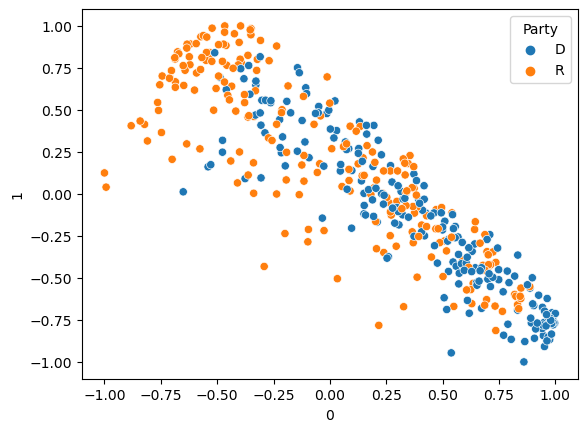

In [121]:


# Plot the senators
p1 = sns.scatterplot(data=U_first_two,x='0',y='1',hue='Party')

# for i in range(0,len(U_first_two)):
#     p1.text(x=U_first_two['0'].iloc[i], y=U_first_two['1'].iloc[i], 
#     s=U_first_two['Name'].iloc[i], horizontalalignment='left', 
#     size='small', color='black')
plt.show()